In [0]:
from fastai import *
from fastai.text import *
from pathlib import Path
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import re

In [0]:
def clean_ascii(text):
    # function to remove non-ASCII characters from data
    return ''.join(i for i in text if ord(i) < 128)

In [0]:
# path to training files
trainfile = 'data.csv'
trainfile2 = 'hateData.txt'

In [0]:
# read 1st training file into dataframe
train_data_bully = pd.read_csv(trainfile, delimiter='\t', header=None, encoding = "latin-1")
train_data_bully.columns =["Tid","Tweet", "Label"] # assing column names

train_data_bully.drop('Tid', axis=1, inplace=True) # remove TweetId column

train_data_bully['Label'] = train_data_bully['Label'].str.strip() # remove whitespaces from class labels

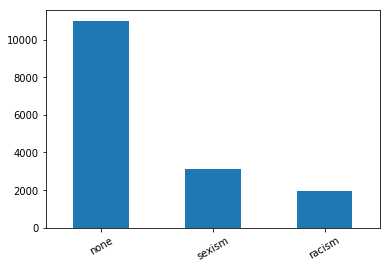

In [16]:
# Plot value counts for rach class in the bully dataset
train_data_bully['Label'].value_counts().plot.bar(rot=30);

In [17]:
# data cleaning & overview
train_data_bully['Tweet'] = train_data_bully['Tweet'].apply(clean_ascii)

train_data_bully.head()

,Tweet,Label
0,RT @colonelkickhead: Another bloody instant re...,none
1,@azzamalirhabi @JihadiA8 This video of the Pes...,none
2,Oh really? No more instant restaurants? THAT'S...,none
3,RT @Benfrancisallen: It hasn't been a good few...,none
4,RT @NoToFeminism: I dont need femisnsn because...,none


In [20]:
# read 2nd training file into dataframe
train_data_hate = pd.read_csv(trainfile2, delimiter='\t', header=None, encoding = "latin-1")
train_data_hate.columns =["Label", "Tweet"] # assing column names
train_data_hate['Tweet'] = train_data_hate['Tweet'].apply(clean_ascii) # clean Tweets

train_data_hate.head() # overview


,Label,Tweet
0,offensive,Warning: penny boards will make you a faggot
1,hatespeech,Fuck dykes
2,hatespeech,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...
3,hatespeech,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkill..."
4,offensive,@Zhugstubble You heard me bitch but any way I'...


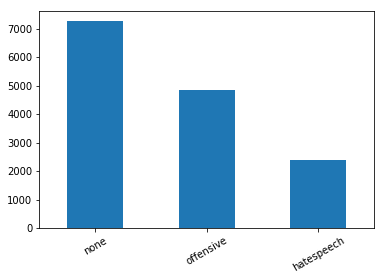

In [21]:
# Class disstribution in hate speech data
train_data_hate['Label'].value_counts().plot.bar(rot=30);

(30559, 2)


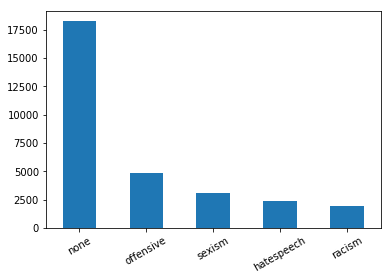

In [22]:
# Combine both (bully & hate) datasets
train_bully = pd.concat([train_data_bully['Label'], train_data_bully['Tweet']], axis=1)
train_combined = train_bully.append(train_data_hate,ignore_index=True)
print(train_combined.shape)
train_combined['Label'].value_counts().plot.bar(rot=30)

In [0]:
# Handle class imbalance in combined dataset

none_class = train_combined.loc[train_combined['Label']=="none"] # Samples which belong to "none" class
rest = train_combined.loc[train_combined['Label']!="none"] #Samples which belong to class other than "none"

#print(none_class.shape)
#print(rest.shape)
#print(none_class.head())

reduced_none = none_class.sample(10000) # sample 10k examples from "none" class
#print(reduced_none.shape)
#print(reduced_none.head())

data = pd.concat([reduced_none, rest], ignore_index=True)

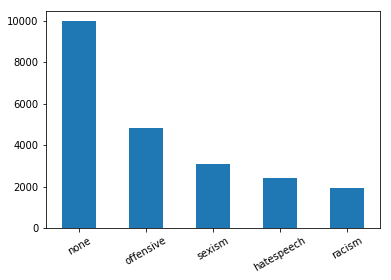

In [24]:
data['Label'].value_counts().plot.bar(rot=30)

In [0]:
# Split data into train and test data with 80:20 ratio
train, test = train_test_split(data, test_size=0.2)

#print(train['Label'].value_counts())
#print(test['Label'].value_counts())

# Write train & test to csv
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_csv('./', 'train.csv', min_freq=1)

In [0]:
# Save the language and classifier model data for re-use
data_lm.save()

In [31]:
data_lm.show_batch()

idx,text
0,a double standards there 's certain rules for dudes and there 's certain rules for fem xxbos xxup rt @parker_bradley xxmaj not sexist but the quality of womens darts is terrible xxbos xxmaj but the joke'll probably fly right over their heads because they 're not local xxup :p xxbos .@thesamgrady i think the reason why xxup mcu is full of white superheroes is because they have fans like you
1,"moment . xxbos @turmoil_cajek shut up you fucking faggot i ve had enough of you xxbos xxmaj blue xxmaj bandaids rule ! ! # mkr xxbos @vandaliser @sajid_fairooz @israeliregime xxmaj where they live tells you everything you need to know , namely , that xxmaj islam is a religion of bigotry xxbos xxmaj do n't wanna have a fag but my shisha pen ent working xxbos xxmaj what do you"
2,"to wear plastic bags over their socks # ayh xxbos @ch_almgren @wmsolomon how is the muzzie invasion in xxmaj sweden ? xxbos @rainbownaziest alright fine , we wo n't help out the next time you niggers have a hurricane xxbos @handlemytweeets 15 by the time we get through it all . # mkr xxbos @kinza504 xxmaj an idiot converts to xxmaj islam . xxmaj what is your point ? xxbos"
3,"police , xxmaj labour council protected the xxmaj muslim rapists.https : / xxbos i wonder if xxmaj lilli xxmaj moore xxmaj coffin that faggot and xxmaj cory xxmaj stubbs @wanderinpoet think their # ssdifraud will continue in 2016 @thessaoig xxbos @just_nafisa @fatimafatwa @es3udi @jrehling 2.3 % my ass . xxmaj at least half of them are murderous lunatics . http : / / t.co / ufqtm3hhyd xxbos @johnsarkiss xxmaj keep"
4,"xxbos xxmaj you fuck wit a lot of ppl i do n't fuck wit - xxmaj that 's why i do n't fuck wit you xxbos @bilalighumman @johnnygjokaj @98halima @cdnkhadija @rfrankh53 xxmaj the xxmaj muslims attacked xxmaj europe 400 years before crusades , microbrain . xxbos @trishesdishes xxmaj are you aware women have more , not fewer legal rights than men ? xxbos xxmaj it xxup does work for everything"


In [0]:
#learner object uses the tokenized language model data
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


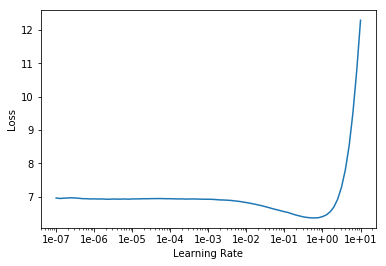

In [33]:
#Find the optimum learning rate
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [34]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,6.488657,5.673153,0.175434,00:20


In [35]:
learn.unfreeze()
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.537621,4.950141,0.236558,00:26
1,5.199552,4.780489,0.264137,00:25
2,4.914314,4.640739,0.280630,00:24
3,4.613081,4.443492,0.296875,00:25
4,4.346132,4.331780,0.308705,00:25
5,4.052248,4.304001,0.314695,00:25
6,3.764867,4.292437,0.319283,00:25
7,3.480791,4.326087,0.320660,00:25
8,3.215195,4.394650,0.319457,00:25
9,2.963219,4.462167,0.322904,00:25


In [0]:
# Save the fine-tuned encoder
learn.save_encoder('ft_enc')

In [0]:
# Classifier model data
data_clas = TextClasDataBunch.from_csv('./', 'train.csv', vocab=data_lm.train_ds.vocab,min_freq=1, bs=32)
data_clas.save()

In [0]:
learn = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


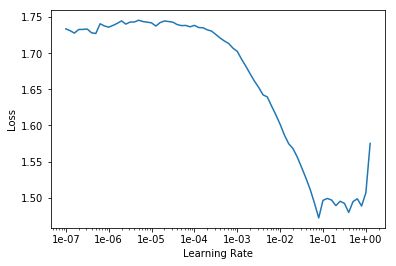

In [39]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.925503,0.745824,0.697055,00:10


In [41]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.720673,0.602590,0.741374,00:11


In [42]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.653969,0.532396,0.763534,00:19


In [43]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.553357,0.529499,0.762412,00:27
1,0.561913,0.515549,0.768864,00:27
2,0.556143,0.503422,0.772230,00:25
3,0.493959,0.493293,0.775316,00:28
4,0.477806,0.502865,0.784853,00:25
5,0.423605,0.505967,0.782609,00:25
6,0.393295,0.505264,0.788219,00:26
7,0.375373,0.513658,0.787377,00:25
8,0.357442,0.515462,0.788499,00:25
9,0.346478,0.516578,0.785133,00:25


In [44]:
# get predictions
preds, targets = learn.get_preds()
predictions = np.argmax(preds, axis=1)
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4
row_0,,,,,
0,201,13,187,0,0
1,16,1425,48,47,75
2,164,53,522,0,2
3,2,66,2,265,3
4,0,84,3,1,386


In [45]:
# Evaluate model performance on test data
test = pd.read_csv('test.csv', encoding = "latin-1")
test.head()

,Label,Tweet
0,hatespeech,A lot of you niggaz is son of a bitch made
1,offensive,I judge you bitches on the niggas you fuck wit...
2,hatespeech,@AnnTelnaes White Trash.
3,offensive,Fuck a lame nigga then you a lame bitch.. Let ...
4,sexism,RT @damong__ I'm not sexist. But fuck marvel f...


In [46]:
# Apply the predict method to produce our prediction
test['Predicted'] = test['Tweet'].apply(lambda row: str(learn.predict(row)[0]))
test.head()

,Label,Tweet,Predicted
0,hatespeech,A lot of you niggaz is son of a bitch made,offensive
1,offensive,I judge you bitches on the niggas you fuck wit...,offensive
2,hatespeech,@AnnTelnaes White Trash.,sexism
3,offensive,Fuck a lame nigga then you a lame bitch.. Let ...,hatespeech
4,sexism,RT @damong__ I'm not sexist. But fuck marvel f...,sexism


In [0]:
# Write the results to csv
test.to_csv("prediction.csv")